<a href="https://colab.research.google.com/github/andybrowning5/QuantumEQ/blob/main/QuantumEQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Dependencies

In [170]:
!pip install qiskit
!pip install qiskit-aer
!pip install librosa
!pip install pylatexenc

Import Statements

In [171]:
import math
import numpy as np
import librosa
from IPython.display import Audio
from librosa import display
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from IPython.display import display

Download Samples

In [178]:
!gdown 1oXtOGJ2gGm70ZYPNUxAFXLkKHgvHMG-H

Downloading...
From: https://drive.google.com/uc?id=1oXtOGJ2gGm70ZYPNUxAFXLkKHgvHMG-H
To: /content/drums.wav
100% 10.1M/10.1M [00:00<00:00, 66.7MB/s]


Functions to Create Gains arrays

In [173]:
## Helper functions
def interpolate_array(base_array, target_length):
  return np.interp(
      np.linspace(0, len(base_array) - 1, target_length),
      np.arange(len(base_array)),
      base_array
  )

def closestPowerOf2(n):
  return 2**math.floor(math.log2(n))

## Create different gain arrays
def make_gaussian_eq_curve(n_qubits, sampling_rate, low_gain=1.0, mid_gain=1.0, high_gain=1.0, width_ratio=0.15):
  n_bins = 2 ** n_qubits // 2
  nyquist = sampling_rate / 2
  x = np.arange(n_bins)

  normal_nyquist = nyquist / 4

  # Use frequency-centered bins based on Nyquist
  center_low = freqToBin(normal_nyquist * 0.2, sampling_rate, n_qubits)
  center_mid = freqToBin(normal_nyquist * 0.5, sampling_rate, n_qubits)
  center_high = freqToBin(normal_nyquist * 0.8, sampling_rate, n_qubits)
  width = int(n_bins * width_ratio)

  low = low_gain * np.exp(-((x - center_low) ** 2) / (2 * width ** 2))
  mid = mid_gain * np.exp(-((x - center_mid) ** 2) / (2 * width ** 2))
  high = high_gain * np.exp(-((x - center_high) ** 2) / (2 * width ** 2))

  gains = low + mid + high
  return np.concatenate([gains, np.zeros(n_bins)])

def make_lowpass_eq_curve(n_qubits, cutoff_freq, sampling_rate, slope=0.05, gain=1.0):
    cutoff_bin = freqToBin(cutoff_freq, sampling_rate, n_qubits)
    n_bins = 2 ** n_qubits // 2
    x = np.arange(n_bins)

    curve = 1 / (1 + np.exp((x - cutoff_bin) / (slope * n_bins)))
    # print(f"Creating Low Pass Curve...cutoff bin: {cutoff_bin}, cutoff freq: {cutoff_freq} Hz")

    gains = gain * curve
    return np.concatenate([gains, np.zeros(n_bins)])


def make_highpass_eq_curve(n_qubits, cutoff_freq, sampling_rate, slope=0.05, gain=1.0):
    cutoff_bin = freqToBin(cutoff_freq, sampling_rate, n_qubits)
    n_bins = 2 ** n_qubits // 2
    x = np.arange(n_bins)

    curve = 1 - 1 / (1 + np.exp((x - cutoff_bin) / (slope * n_bins)))
    # print(f"Creating High Pass Curve...cutoff bin: {cutoff_bin}, cutoff freq: {cutoff_freq} Hz")

    gains = gain * curve
    return np.concatenate([gains, np.zeros(n_bins)])

def freqToBin(freq, sampling_rate, n_qubits):
    nyquist = sampling_rate / 2
    n_bins = 2 ** n_qubits
    bin_width = nyquist / (n_bins // 2)
    return int(np.clip(freq / bin_width, 0, n_bins - 1))

def frequency_range(n_qubits, fs):
    N = 2 ** n_qubits
    delta_f = fs / N
    f_min = 0
    f_max = fs / 2  # Nyquist frequency
    return f_min, f_max, delta_f

def mirror_gains(half_gains):
    return np.concatenate([half_gains, half_gains[::-1]])

Quantum EQ Circuit

In [174]:
## Quantum EQ Circuit Function
#Encodes a normalized set of amplitudes from the audio samples onto the states of the qubits
def create_encoded_qc(samples, n_qubits):
    amplitudes = len(samples)
    q = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q)

    norm = np.linalg.norm(samples)
    if norm == 0 or np.isnan(norm):
        raise ValueError("Attempted to encode an invalid or silent sample chunk.")

    normalized_amplitudes = samples / norm
    qc.initialize(normalized_amplitudes, [q[i] for i in range(n_qubits)])
    return qc

def quantum_eq(samples, n_qubits, gains, iterations):
  final_outputwave = np.array([])

  ## Check that # of iterations will not overflow the sample
  maxIterations = int(len(samples)/2**n_qubits)
  if iterations > maxIterations:
    iterations = maxIterations
    print("Iterations overlfow, setting iterations to " + str(maxIterations))
  else:
    print("Iterations = " + str(iterations))

  print("Each iteration covers " + str(2**n_qubits)+" samples")
  print("Covering a total of " + str(2**n_qubits * iterations)+ " samples")
  print("Creating Quantum Circuit with " + str(n_qubits) + " qubits")

  for i in range(iterations):
    smallSamples = samples[2**n_qubits * i:2**n_qubits * (i+1)]
    ## Perform QFT and check that smallSample is not empty
    try:
        QEQ1 = create_encoded_qc(smallSamples, n_qubits)
    except ValueError as e:
        print(f"Skipping chunk {i}: {e}")
        final_outputwave = np.concatenate([final_outputwave, np.zeros_like(smallSamples)])
        continue

    QEQ1.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    ## Save state vector from QFT
    qft_state = Statevector.from_instruction(QEQ1)


    # Save the original norm of the chunk
    original_norm = np.linalg.norm(smallSamples)

    ## Apply EQ and normalize
    if np.allclose(gains, 1):
      eq_amplitudes = qft_state.data  # Skip normalization if no EQ
    else:
        eq_amplitudes = qft_state.data * gains

    ## Perform Inverse QFT
    QEQ2 = QuantumCircuit(n_qubits)
    QEQ2.append(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))

    ## Extract final state and save as waveform
    final_state = Statevector(eq_amplitudes).evolve(QEQ2)

    ## Recover amplitude scale
    chunk = final_state.data.real
    chunk = chunk * original_norm  # Scale back to original chunk energy
    chunk = np.clip(chunk, -1.0, 1.0)

    final_outputwave = np.concatenate([final_outputwave, chunk])

    ## Print status
    if (iterations <= 100):
      if (i % 10 == 0):
        print("Iteration " + str(i) + "/" + str(iterations))
    else:
       if (i % 100 == 0):
        print("Iteration " + str(i) + "/" + str(iterations))
  print("EQ Complete")
  return final_outputwave

Plotting Functions

In [182]:
def plotEQ(output_waveform, sampling_rate, title="Waveform", color = "blue"):
  ## Plot Results on entire sample
  plt.figure(figsize=(12, 8))
  t = np.linspace(0, len(output_waveform)/sampling_rate, len(output_waveform), endpoint=False)

  plt.subplot(2, 1, 1)
  plt.plot(t, output_waveform, label="Processed Audio", color=color)
  plt.xlabel("Time [s]")
  plt.ylabel("Amplitude")
  plt.title(title)
  plt.legend()

  plt.tight_layout()
  plt.show()

def plot_gains(gains, sampling_rate, n_qubits, max_freq=48000, title="Gains"):
    # Compute frequency bins
    N = 2 ** n_qubits            # total number of frequency bins
    half_bins = N // 2           # we only need up to Nyquist
    delta_f = (sampling_rate / 2) / half_bins
    freqs = np.arange(N) * delta_f

    # Convert gains to array in case it's a list
    gains = np.array(gains)

    # Filter frequencies to the range 10 Hz to 24 kHz
    valid_indices = (freqs >= 10) & (freqs <= 24000)
    freqs = freqs[valid_indices]
    gains = gains[valid_indices]

    plt.figure(figsize=(10, 4))
    # Plot on a logarithmic scale for the x-axis
    plt.semilogx(freqs, gains, marker='o')

    # Set the x-axis limits from 10 Hz to 24 kHz
    plt.xlim(10, 24000)

    # Define custom ticks (and labels) at typical EQ frequencies
    plt.xticks([10, 100, 1000, 10000, 24000],
               ["10", "100", "1k", "10k", "24k"])

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Gain")
    plt.title(title)
    plt.grid(True, which='both', linestyle='--')
    plt.show()

def createRandomSamples(samples, output_waveform, n, m):
  samples_list = []
  starts = []
  ends = []
  eq_list = []
  for i in range(m):
    start = np.random.randint(0, len(output_waveform) - n)
    end = start + n
    starts.append(start)
    ends.append(end)
    samples_list.append(samples[start:end])
    eq_list.append(output_waveform[start:end])

  return samples_list, eq_list, starts, ends

Need to do more research on what part of the frequency bins to use. Current understanding is that Nyquist is half the full frequency spectrum produced by the FFT, which represents the real part of the frequency spectrum. Not sure if I need to do anything to the imaginary part of the spectrum or if messing with it will even do anything.

Sample size = 1257601
Sampling Rate = 48000
Original Audio:


Min frequency: 0 Hz
Max frequency: 24000.0 Hz
Frequency bin width: 46.875 Hz
Number of frequency bins: 1024
Creating Low Pass Curve...cutoff bin: 128, cutoff freq: 6000 Hz
Creating High Pass Curve...cutoff bin: 128, cutoff freq: 6000 Hz


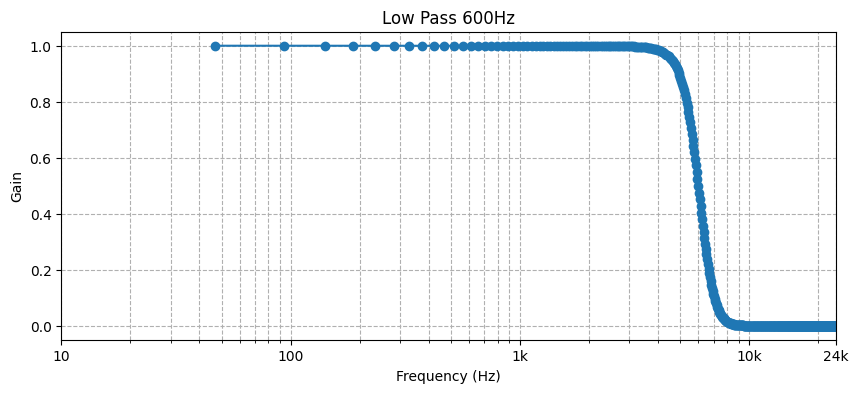

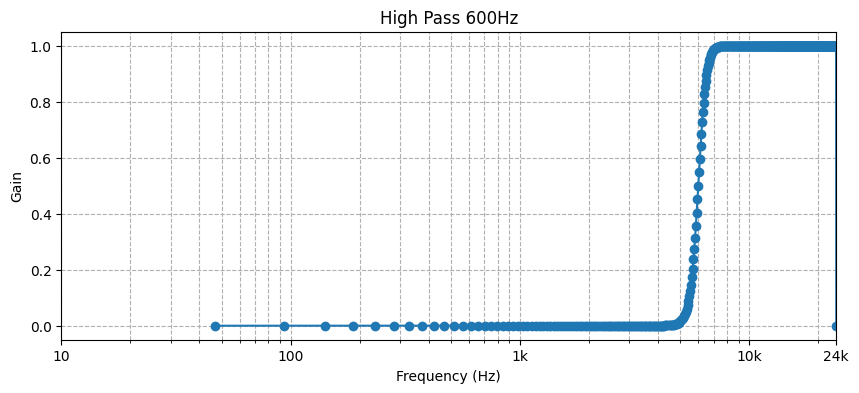

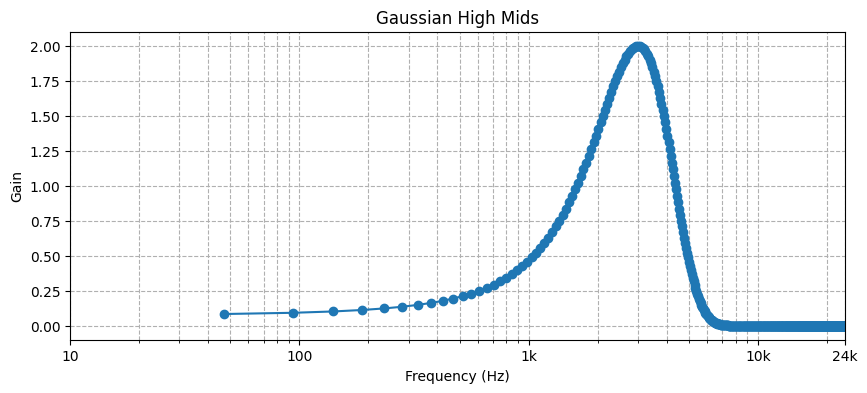

Iterations = 200
Each iteration covers 1024 samples
Covering a total of 204800 samples
Creating Quantum Circuit with 10 qubits
Iteration 0/200
Iteration 100/200
EQ Complete
Iterations = 200
Each iteration covers 1024 samples
Covering a total of 204800 samples
Creating Quantum Circuit with 10 qubits
Iteration 0/200
Iteration 100/200
EQ Complete
Iterations = 200
Each iteration covers 1024 samples
Covering a total of 204800 samples
Creating Quantum Circuit with 10 qubits
Iteration 0/200
Iteration 100/200
EQ Complete
Unaltered Audio Sample:


EQ Audio Sample High Pass 6000Hz:


EQ Audio Sample Low Pass 6000Hz:


EQ Audio Sample Gaussian High Mids:


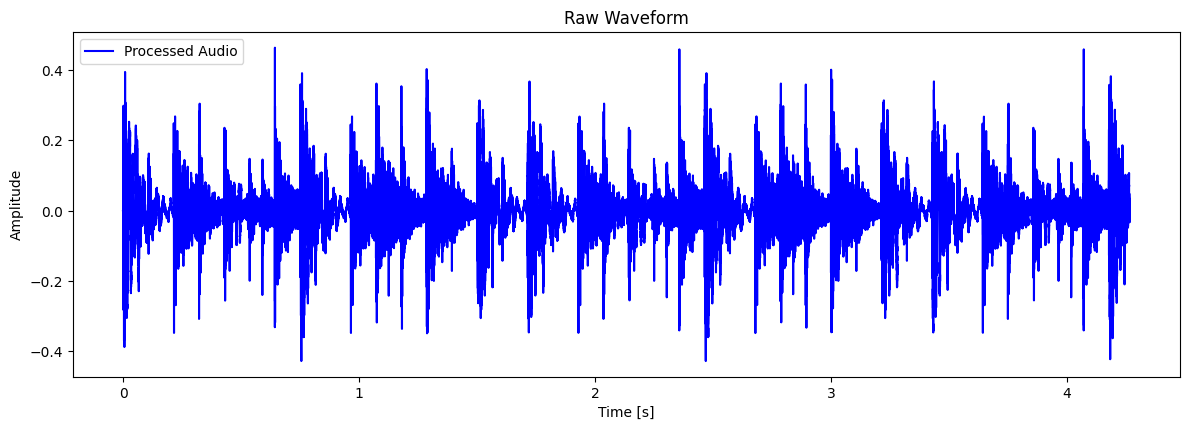

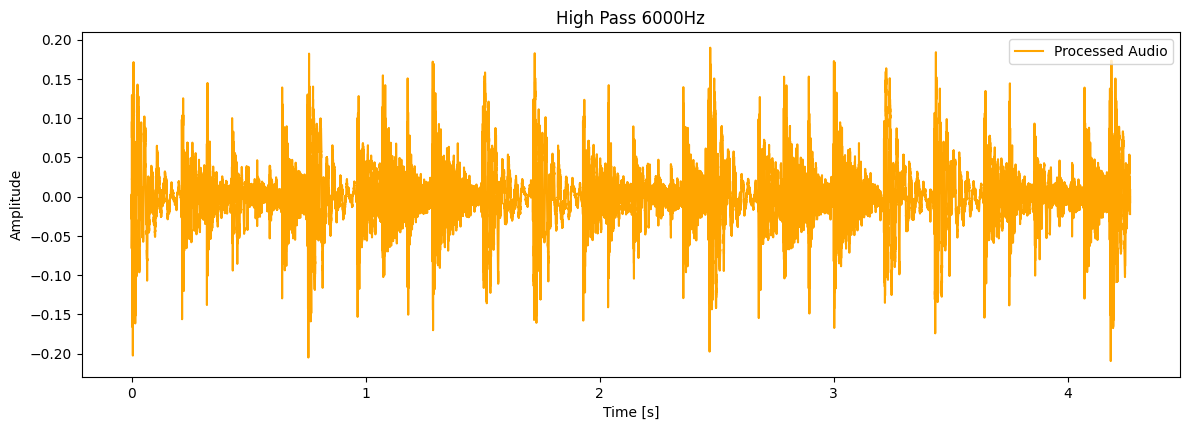

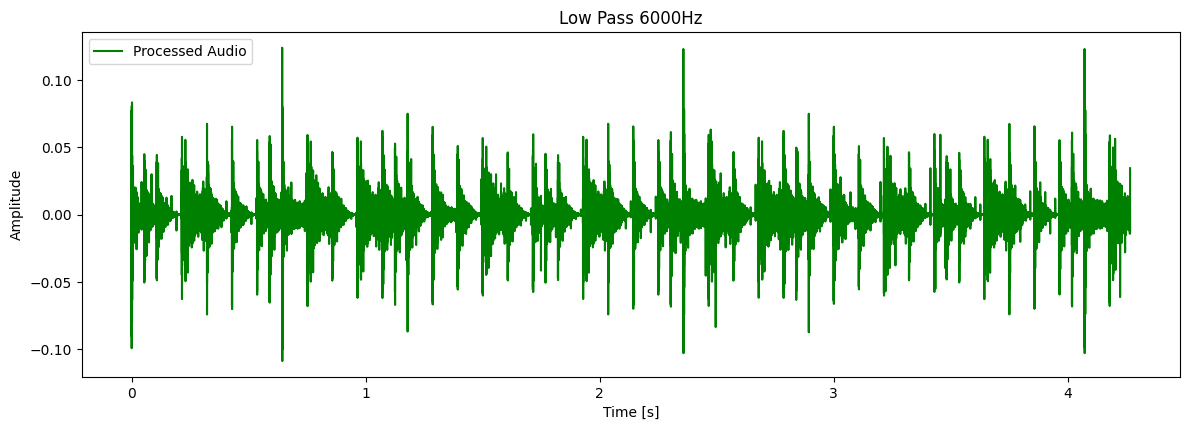

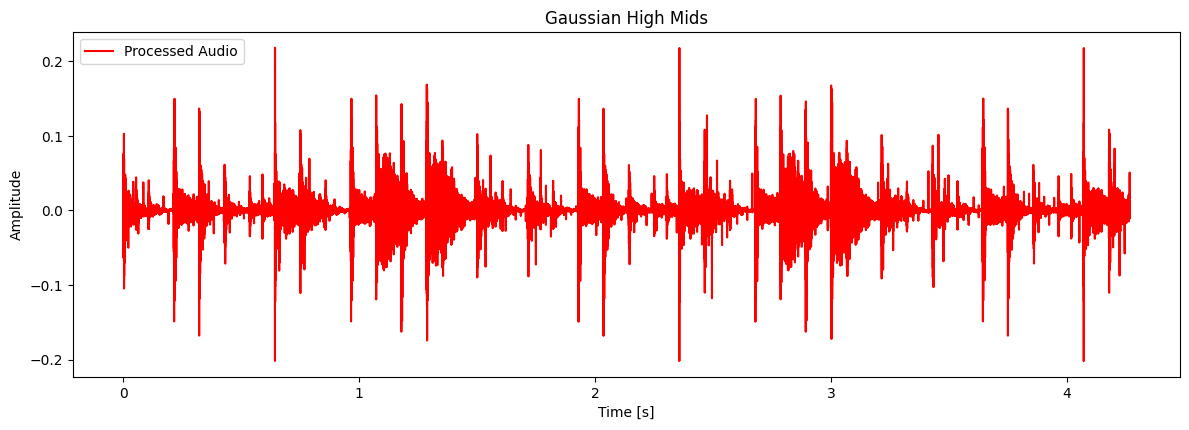

In [184]:
## Read file
file_path = './drums.wav'
samples, sampling_rate= librosa.load(file_path, sr = None, mono = True, offset= 0.0, duration = None)
samples = samples.astype('float64')

print("Sample size = " + str(samples.size))
print("Sampling Rate = " + str(sampling_rate))

print("Original Audio:")
display(Audio(samples, rate = sampling_rate))

n_qubits = 10 #number of qubits that will be used to encode samples in QFT
n_bins = 2**n_qubits

f_min, f_max, delta_f = frequency_range(n_qubits=n_qubits, fs=sampling_rate)
print(f"Min frequency: {f_min} Hz")
print(f"Max frequency: {f_max} Hz")
print(f"Frequency bin width: {delta_f} Hz")
print(f"Number of frequency bins: {n_bins}")

## Create gains options
gains = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
smoothGains = interpolate_array(gains, int(2**n_qubits // 2))
smoothGains = mirror_gains(smoothGains)
gainOnes = np.ones(2**n_qubits)

gaussianGains = make_gaussian_eq_curve(
    n_qubits,
    sampling_rate,
    low_gain=0,
    mid_gain=2,
    high_gain=0,
    width_ratio=0.05
)
lp_curve = make_lowpass_eq_curve(n_qubits, cutoff_freq=6000, sampling_rate=sampling_rate, slope=0.02)
hp_curve = make_highpass_eq_curve(n_qubits, cutoff_freq=6000, sampling_rate=sampling_rate, slope=0.01)


## Plot Gains
plot_gains(lp_curve, sampling_rate=sampling_rate, n_qubits=n_qubits, max_freq=sampling_rate/2, title="Low Pass 600Hz")
plot_gains(hp_curve, sampling_rate=sampling_rate, n_qubits=n_qubits, max_freq=sampling_rate/2, title="High Pass 600Hz")
plot_gains(gaussianGains, sampling_rate=sampling_rate, n_qubits=n_qubits, max_freq=sampling_rate/2, title="Gaussian High Mids")


## Set number of iterations for EQ to run to cover entire sample
iterations = 200

## Perform Quantum EQ
output_waveform = quantum_eq(samples, n_qubits, lp_curve, iterations)
output_waveform2 = quantum_eq(samples, n_qubits, hp_curve, iterations)
output_waveform3 = quantum_eq(samples, n_qubits, gaussianGains, iterations)


samples = samples[:len(output_waveform)]

print("Unaltered Audio Sample:")
display(Audio(samples, rate = sampling_rate))
print("EQ Audio Sample High Pass 6000Hz:")
display(Audio(output_waveform, rate = sampling_rate))
print("EQ Audio Sample Low Pass 6000Hz:")
display(Audio(output_waveform2, rate = sampling_rate))
print("EQ Audio Sample Gaussian High Mids:")
display(Audio(output_waveform3, rate = sampling_rate))

plotEQ(samples, sampling_rate, title = "Raw Waveform")
plotEQ(output_waveform, sampling_rate, title = "High Pass 6000Hz", color = "orange")
plotEQ(output_waveform2, sampling_rate, title = "Low Pass 6000Hz", color = "green")
plotEQ(output_waveform3, sampling_rate, title = "Gaussian High Mids", color = "red")

In [177]:
samples, sampling_rate= librosa.load(file_path, sr = None, mono = True, offset= 0.0, duration = None)
samples = samples.astype('float64')


n_qubits = 10
samples = samples[:2**n_qubits]
audio_qc = create_encoded_qc(samples, n_qubits)
audio_qc1 = audio_qc.compose(QFT(num_qubits=n_qubits, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft'))
audio_qc1.measure_all()
shotno=1024
backend = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(audio_qc1, backend)
job = backend.run(compiled_circuit, shots=shotno)
results = job.result()
counts = results.get_counts(audio_qc1)
def get_fft_from_counts(counts, n_qubits):
    """
    Returns the counts in order of the digital value of the key which is the measured qbit state, i.e. in frequency order
    """
    out = []
    keys = counts.keys()
    for i in range(2**n_qubits):
        id = get_bit_string(i, n_qubits)
        if(id in keys):
            out.append(counts[id])
        else:
            out.append(0)

    return out

def get_bit_string(n, n_qubits):
    """
    Returns the binary string of an integer with n_qubits characters
    """

    assert n < 2**n_qubits, 'n too big to binarise, increase n_qubits or decrease n'

    bs = "{0:b}".format(n)
    bs = "0"*(n_qubits - len(bs)) + bs

    return bs

def plot_samples(samples,factor):

    n=len(samples)
    x = np.arange(n)
    x=x*factor
    y = samples[0:n]
    plt.title("Frequency Distribution")
    plt.xlabel("frequency")
    plt.ylabel("counts")
    plt.plot(x,y,"o")
    plt.plot(x,y)

fft = get_fft_from_counts(counts, n_qubits)[:samples.size//2]
plot_samples(fft[0:50],sampling_rate/samples.size)

#Find the frequencies
max_value = max(fft)
max_index = fft.index(max_value)
detected_frequency = []
#find the indexes with counts larger than half the maximum count
for i in range(math.floor(len(fft)/2)):
    if fft[i] > max_value/2:
        detected_frequency.append(i)
#tunr the indices into frequencies by multiplying by sampling_rate/samples.size
for j in range(len(detected_frequency)):
    detected_frequency[j]=detected_frequency[j]*(sampling_rate/samples.size)

print(detected_frequency)

[93.75]
